In [16]:
import vae
from model import Model
from pytorch_lightning import Trainer
import yaml
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from pathlib import Path
from dataloader import Dataset
from pytorch_lightning.plugins import DDPPlugin
from torchmetrics.image.inception import InceptionScore
from torchmetrics.image.fid import FrechetInceptionDistance
from torchvision.utils import make_grid
import torchvision.transforms as T
from torchvision.transforms.functional import to_pil_image
import torch


In [2]:
# interpret given hyperparameters
with open('./conf/model/betavae.yaml', 'r') as file:
    modelconfig = yaml.safe_load(file)

with open('./conf/data/celeba.yaml', 'r') as file:
    dataconfig = yaml.safe_load(file)
    modelconfig['model_params']['in_channels'] = dataconfig['in_channels']

In [3]:
vae = vae.beta_vae(**modelconfig['model_params'])
experiment = Model(vae, modelconfig['exp_params'])
checkpoint = torch.load('logs/betavae/version_0/checkpoints/last.ckpt')
experiment.load_state_dict(checkpoint['state_dict'])

/home/sonia/miniconda3/envs/py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/sonia/miniconda3/envs/py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `FrechetInceptionDistance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


<All keys matched successfully>

In [4]:
data = Dataset(**dataconfig, pin_memory=len(modelconfig['trainer_params']['gpus']) != 0)
data.setup()
test = data.test_dataloader()

Files already downloaded and verified
Files already downloaded and verified


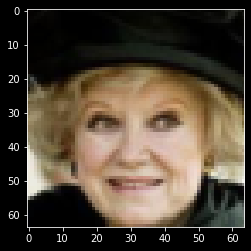

In [5]:
img=test.dataset[0][0]
plt.imshow( img.permute(1, 2, 0)  )

In [6]:
ex, label = next(iter(test)) #get random batch
print(ex.shape,label.shape)

torch.Size([144, 3, 64, 64]) torch.Size([144, 40])


In [7]:
mu, var = vae.encode(ex)
print(mu.shape, var.shape) #examples X latent dims

torch.Size([144, 128]) torch.Size([144, 128])


In [8]:
decode, _, mu, log_var = vae.forward(ex)

In [9]:
i=5 #dimension to change
mup = mu
mup[:,i]=mup[:,i]+log_var[:,i]
mum = mu
mum[:,i]=mum[:,i]-log_var[:,i]
zp =vae.reparameterize(mup, log_var)
zm =vae.reparameterize(mum, log_var)

In [10]:
decodep=vae.decode(zp)
decodem=vae.decode(zm)

In [11]:
im=decode[0,:,:,:] #get 0th image
imp=decodep[0,:,:,:]
imm=decodem[0,:,:,:]

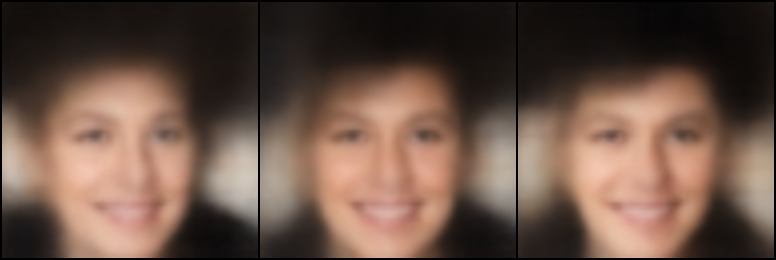

In [17]:
ims = [imm, im, imp]
to_pil_image(make_grid([T.Resize(256)(i) for i in ims]))